# COVID-19 Fake News Classification and Misinformation Detection using FLAN-T5 Model
In this notebook, we will perform the following steps:
1. **Data Preprocessing**
2. **Model Fine-tuning**
3. **Evaluation**
4. **Confidence Scoring**
5. **Misinformation Classification (True, False, Misleading)**

We will be using the FLAN-T5 Large model for the task.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1: Install the following:

In [6]:
!pip install pytorch-transformers
!pip install transformers
!pip install nltk
!pip install preprocessor
!pip install torch
!pip install sentencepiece
!pip install datasets>=2.12.0
!pip install numpy==1.24.4
!pip install fsspec==2025.3.0
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import preprocessor as p
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer


## Reducing the datasets to 70 - 20 - 10 Split
Explicitly sets the dataset sizes:

Train: 1498

Dev/validation: 428

Test: 214

## Step 2: Load Data
Next, I will load my cleaned and reduced datasets into the notebook. The datasets are already cleaned and stored in Reduced_Covid_Train.json, Reduced_Covid_Dev.json, Reduced_Covid_Test.json.

In [3]:
# Update the paths to reflect Google Drive structure
train_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/Reduced_Covid_Train.json', lines=True)
val_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/Reduced_Covid_Dev.json', lines=True)
test_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/Reduced_Covid_Test_Answer.json', lines=True)

train_df_100 = train_df.sample(n=100)

train_df_100.to_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/Reduced_Covid_Train_100.json', orient='records', lines=True)

# Check if the data is loaded correctly
print(train_df.head())
print(val_df.head())
print(test_df.head())
print(train_df_100.head())

     id                                              tweet  label
0   883  An image accompanies the text: The Italian Pri...  False
1  2324  U.S. President Donald Trump tweeted that Barac...  False
2  3337         PCR tests cannot detect a new coronavirus.  False
3  3606  Coronavirus: European countries impose new res...   True
4   622  Sadly there are 11 people with COVID-19 in hos...   True
     id                                              tweet  label
0   887  if we test aggressively test through RT PCR, T...  False
1  2104  Victoria has received a lot of attention for e...  False
2  1364  Pope Authorizes Social Distance Baptisms Using...  False
3   737  COVAX is a global initiative working with coun...   True
4   545  #Coronavirus deaths are rising in 23 states; c...   True
     id                                              tweet  label
0   517  This chart makes clear what has been true all ...   True
1   716  CDC updates &amp; expands list of those at ris...   True
2  1222  A

In [4]:
# Current classification function can be enhanced:
def classify_with_prompt(claim, explanation):
    prompt = (
        f"Classify this COVID-19 related claim as 'True' or 'False' based on its veracity:\n"
        f"Claim: {claim}\n"
        f"Context: {explanation}\n"
        "Answer with just one word: 'True' or 'False'"
    )

    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            temperature=0.7,
            num_beams=3
        )

    result = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().lower()

    # More robust output parsing
    if any(word in result for word in ["true", "correct", "accurate"]):
        return "True"
    elif any(word in result for word in ["false", "incorrect", "inaccurate"]):
        return "False"
    return "Unknown"

## Benchmarking with only 100 parameters
We have assigned 100 parameters from the train dataset, and benchmarked to see the benchmark accuracy.

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Benchmarking:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Benchmarking: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Benchmark Accuracy:  46.0000000000%


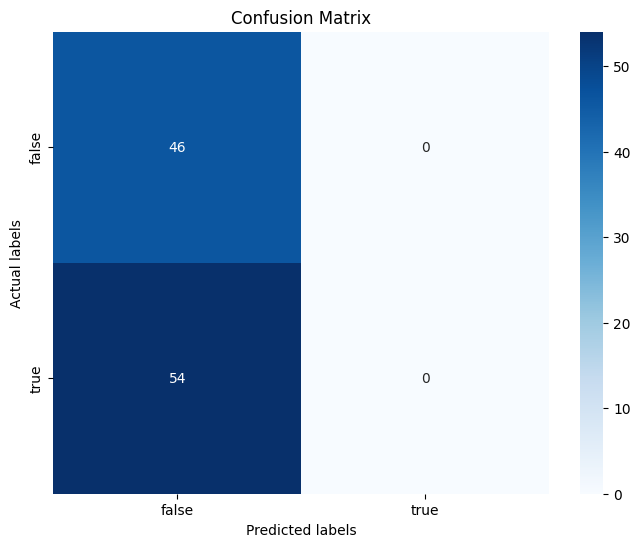

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       false       0.46      1.00      0.63        46
        true       0.00      0.00      0.00        54

    accuracy                           0.46       100
   macro avg       0.23      0.50      0.32       100
weighted avg       0.21      0.46      0.29       100



In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Initialize the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large").to("cuda")

# Assuming `train_df_100` is a DataFrame that contains the tweets and labels
results = []
correct = 0
total = 0

# Arrays to hold the predicted and actual labels
predicted_labels = []
actual_labels = []

for idx, row in tqdm(train_df_100.iterrows(), total=len(train_df_100), desc="Benchmarking"):
    predicted = classify_with_prompt(row["tweet"], "No explanation available")
    actual = row["label"]

    predicted = str(predicted).lower()  # Convert to lowercase string for consistency
    actual = str(actual).lower()  # Convert to lowercase string for consistency

    # Append predicted and actual labels to the lists
    predicted_labels.append(predicted)
    actual_labels.append(actual)

    results.append({
        "claim": row["id"],
        "predicted": predicted,
        "actual": actual
    })

    # Check if prediction matches actual
    if predicted == actual:
        correct += 1
    total += 1

# Calculate accuracy
accuracy = correct / total
print(f"\nBenchmark Accuracy: {accuracy: .10%}")

# Now, generate the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Create and plot the confusion matrix
labels = sorted(set(actual_labels + predicted_labels))  # Get all unique labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion Matrix')
plt.show()

# Optional: Calculate additional classification metrics
from sklearn.metrics import classification_report

print(classification_report(actual_labels, predicted_labels))


# Benchmarking with 1000 samples using Train_df dataset

Benchmarking:   0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Benchmarking: 100%|██████████| 1000/1000 [03:56<00:00,  4.24it/s]


Benchmark Accuracy:  47.8000000000%


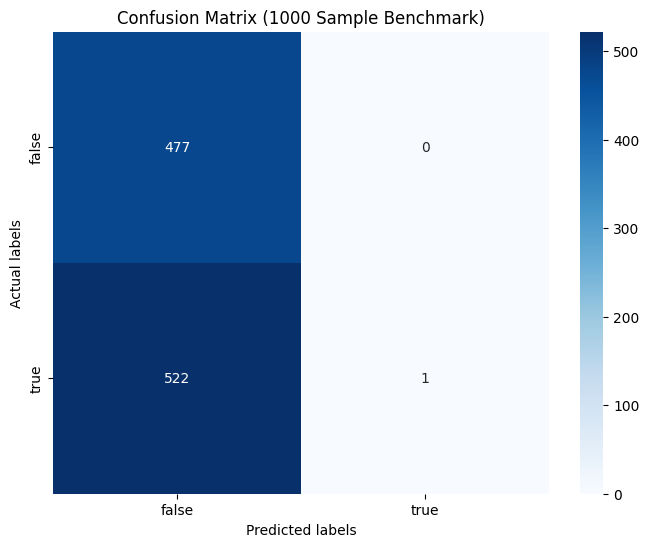

              precision    recall  f1-score   support

       false       0.48      1.00      0.65       477
        true       1.00      0.00      0.00       523

    accuracy                           0.48      1000
   macro avg       0.74      0.50      0.33      1000
weighted avg       0.75      0.48      0.31      1000



In [7]:
import pandas as pd

# Load the original training data
train_df = pd.read_json(
    '/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/Reduced_Covid_Train.json',
    lines=True
)

# Randomly sample 1000 claims
train_df_1000 = train_df.sample(n=1000)

# Save the sampled subset (optional)
train_df_1000.to_json(
    '/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/Reduced_Covid_Train_1000.json',
    orient='records',
    lines=True
)
def classify_with_prompt(claim, explanation):
    prompt = (
        f"Classify this COVID-19 related claim as 'True' or 'False' based on its veracity:\n"
        f"Claim: {claim}\n"
        f"Context: {explanation}\n"
        "Answer with just one word: 'True' or 'False'"
    )

    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            temperature=0.7,
            num_beams=3
        )

    result = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().lower()

    if any(word in result for word in ["true", "correct", "accurate"]):
        return "True"
    elif any(word in result for word in ["false", "incorrect", "inaccurate"]):
        return "False"
    return "Unknown"
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large").to("cuda")

results = []
predicted_labels = []
actual_labels = []
correct = 0
total = 0

for idx, row in tqdm(train_df_1000.iterrows(), total=len(train_df_1000), desc="Benchmarking"):
    predicted = classify_with_prompt(row["tweet"], "No explanation available")
    actual = row["label"]

    predicted = str(predicted).lower()
    actual = str(actual).lower()

    predicted_labels.append(predicted)
    actual_labels.append(actual)

    results.append({
        "claim": row["id"],
        "predicted": predicted,
        "actual": actual
    })

    if predicted == actual:
        correct += 1
    total += 1

# Accuracy
accuracy = correct / total
print(f"\nBenchmark Accuracy: {accuracy: .10%}")

# Confusion Matrix
cm = confusion_matrix(actual_labels, predicted_labels)
labels = sorted(set(actual_labels + predicted_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion Matrix (1000 Sample Benchmark)')
plt.show()

# Classification Report
print(classification_report(actual_labels, predicted_labels))


## Tweet Classification for Truth Evaluation using Prompt Engineering with 100 samples
1. Cleans the Tweet:

It removes any URLs and special characters (like punctuation) from the tweet, leaving only words and spaces.

2. Classifies the Tweet:

It takes the cleaned tweet and sends it to a function that checks if the statement in the tweet is true or false, based on a pre-defined prompt.

3. Selects a Tweet:

It picks a specific tweet from a dataset (at index 5) and prints out its ID, text, and the label (True/False).

4. Measures Time:

It measures how long it takes to classify the tweet and prints the time taken for the process.

In [8]:
import re
import time
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# === Initialize FLAN-T5 model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large").to(device)

# === Text cleaning function ===
def clean_tweet(tweet):
    """Clean tweet text by removing URLs and special characters"""
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)
    tweet = re.sub(r"[^a-zA-Z0-9\s.,!?]", "", tweet)  # Keep basic punctuation
    return tweet.strip()

# === Prompt generation function ===
def generate_prompt(tweet):
    """Generate classification prompt with instructions and examples"""
    cleaned = clean_tweet(tweet)

    system_prompt = """You are a fact-checking AI specialized in COVID-19 misinformation detection.
Analyze the tweet and classify its veracity based on WHO guidelines and scientific consensus."""

    classification_rules = """
RULES:
1. If the claim aligns with WHO/CDC guidelines → True
2. If the claim contradicts scientific consensus → False
3. If the claim promotes conspiracy theories → False
4. If the claim lacks evidence → False
5. If the claim is ambiguous → False (default to caution)
"""

    examples = """
EXAMPLES:
Tweet: "Vaccines reduce COVID-19 transmission"
Response: True

Tweet: "Ivermectin cures COVID-19"
Response: False

Tweet: "COVID-19 was created in a lab"
Response: False

Tweet: "NASA confirmed that there is water on the moon."
Response: True

Tweet: "Drinking bleach cures COVID-19."
Response: False

Tweet: "5G towers spread COVID-19."
Response: False

Tweet: "COVID-19 vaccines have been shown to reduce hospitalization and death rates."
Response: True

Tweet: "Bill Gates predicted and simulated the COVID-19 pandemic."
Response: False

Tweet: "New Zealand Prime Minister declared the country COVID-19 free during a visit to a temple."
Response: False

Tweet: "Hospitals in Texas and California had dashboard issues due to data reporting changes."
Response: True

Tweet: "Church gatherings were limited to 10 people during lockdowns in New Zealand."
Response: True
"""

    return f"""
{system_prompt}
{classification_rules}
{examples}

TWEET TO CLASSIFY: "{cleaned}"
ONLY respond with "True" or "False":
""".strip()

# === Classification function with error handling ===
def classify_with_prompt(prompt):
    """Classify tweet using the model with robust error handling"""
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        max_length=512,
        truncation=True,
        padding="max_length"
    ).to(device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=2,
        do_sample=False,
        temperature=0.1,
        num_beams=3,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )

    return tokenizer.decode(
        outputs[0],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    ).strip().capitalize()

# === Main classification function ===
def classify_tweet(tweet):
    """Classify a single tweet with retry logic"""
    prompt = generate_prompt(tweet)

    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = classify_with_prompt(prompt)
            if response.lower() in ['true', 'false']:
                return response.capitalize()
            elif attempt == max_retries - 1:
                return "False"  # Default to False if unclear
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"Error processing tweet: {e}")
                return "False"
            time.sleep(1)
    return "False"

# === Batch classification function ===
def batch_classify(tweets, batch_size=8):
    """Process multiple tweets efficiently"""
    results = []
    for i in range(0, len(tweets), batch_size):
        batch = tweets[i:i+batch_size]
        batch_prompts = [generate_prompt(tweet) for tweet in batch]

        inputs = tokenizer(
            batch_prompts,
            return_tensors="pt",
            max_length=512,
            truncation=True,
            padding=True
        ).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=2,
                do_sample=False,
                temperature=0.1,
                num_beams=3
            )

        batch_results = tokenizer.batch_decode(
            outputs,
            skip_special_tokens=True
        )

        results.extend([res.strip().capitalize() for res in batch_results])
        torch.cuda.empty_cache()

    return results

# === Evaluation function ===
def evaluate_model(df):
    """Evaluate model performance on a dataset"""
    y_true = []
    y_pred = []
    results = []
    total_times = []

    for _, row in df.iterrows():
        start_time = time.time()
        predicted = classify_tweet(row["tweet"])
        elapsed = time.time() - start_time

        actual = str(row["label"]).strip().lower()

        y_true.append(actual)
        y_pred.append(predicted.lower())
        total_times.append(elapsed)

        results.append({
            "id": row.get("id", "N/A"),
            "tweet": row["tweet"],
            "actual": actual.capitalize(),
            "predicted": predicted,
            "time_sec": elapsed,
            "correct": predicted.lower() == actual
        })

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label="true", zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label="true", zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label="true", zero_division=0)
    avg_time = sum(total_times) / len(total_times)

    print("\n" + "="*50)
    print(f"Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1-Score: {f1:.2%}")
    print(f"Average processing time: {avg_time:.4f} sec/tweet")
    print("="*50 + "\n")

    return pd.DataFrame(results)

# === Main execution ===
if __name__ == "__main__":
    # Load data
    sample_path = '/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/Reduced_Covid_Train_100.json'
    train_df = pd.read_json(sample_path, lines=True)
    train_df_100 = train_df.sample(100, random_state=42)  # Reproducible sampling

    # Evaluate
    results_df = evaluate_model(train_df_100)

# Save results
results_df.to_csv("/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/classification_results.csv", index=False)
print("Evaluation complete. Results saved to classification_results.csv")


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



Evaluation Metrics:
Accuracy: 67.00%
Precision: 69.09%
Recall: 70.37%
F1-Score: 69.72%
Average processing time: 0.2269 sec/tweet

Evaluation complete. Results saved to classification_results.csv


# Health Claim Classification prompt engineering 1000 samples

In [9]:
import re
import time
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# === Initialize FLAN-T5 model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large").to(device)

# === Text cleaning function ===
def clean_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)
    tweet = re.sub(r"[^a-zA-Z0-9\s.,!?]", "", tweet)
    return tweet.strip()

# === Prompt generation function ===
def generate_prompt(tweet):
    cleaned = clean_tweet(tweet)

    system_prompt = """You are a fact-checking AI specialized in COVID-19 misinformation detection.
Analyze the tweet and classify its veracity based on WHO guidelines and scientific consensus."""

    classification_rules = """
RULES:
1. If the claim aligns with WHO/CDC guidelines → True
2. If the claim contradicts scientific consensus → False
3. If the claim promotes conspiracy theories → False
4. If the claim lacks evidence → False
5. If the claim is ambiguous → False (default to caution)
"""

    examples = """
EXAMPLES:
Tweet: "Vaccines reduce COVID-19 transmission"
Response: True

Tweet: "Ivermectin cures COVID-19"
Response: False

Tweet: "COVID-19 was created in a lab"
Response: False

Tweet: "NASA confirmed that there is water on the moon."
Response: True

Tweet: "Drinking bleach cures COVID-19."
Response: False

Tweet: "5G towers spread COVID-19."
Response: False

Tweet: "COVID-19 vaccines have been shown to reduce hospitalization and death rates."
Response: True

Tweet: "Bill Gates predicted and simulated the COVID-19 pandemic."
Response: False

Tweet: "New Zealand Prime Minister declared the country COVID-19 free during a visit to a temple."
Response: False

Tweet: "Hospitals in Texas and California had dashboard issues due to data reporting changes."
Response: True

Tweet: "Church gatherings were limited to 10 people during lockdowns in New Zealand."
Response: True
"""

    return f"""
{system_prompt}
{classification_rules}
{examples}

TWEET TO CLASSIFY: "{cleaned}"
ONLY respond with "True" or "False":
""".strip()

# === Classification function with retry ===
def classify_with_prompt(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True, padding="max_length").to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=2,
        do_sample=False,
        temperature=0.1,
        num_beams=3,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True).strip().capitalize()

def classify_tweet(tweet):
    prompt = generate_prompt(tweet)
    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = classify_with_prompt(prompt)
            if response.lower() in ['true', 'false']:
                return response.capitalize()
            elif attempt == max_retries - 1:
                return "False"
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"Error processing tweet: {e}")
                return "False"
            time.sleep(1)
    return "False"

# === Evaluation function ===
def evaluate_model(df):
    y_true, y_pred, total_times, results = [], [], [], []

    for _, row in df.iterrows():
        start_time = time.time()
        predicted = classify_tweet(row["tweet"])
        elapsed = time.time() - start_time

        actual = str(row["label"]).strip().lower()
        y_true.append(actual)
        y_pred.append(predicted.lower())
        total_times.append(elapsed)

        results.append({
            "id": row.get("id", "N/A"),
            "tweet": row["tweet"],
            "actual": actual.capitalize(),
            "predicted": predicted,
            "time_sec": elapsed,
            "correct": predicted.lower() == actual
        })

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label="true", zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label="true", zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label="true", zero_division=0)
    avg_time = sum(total_times) / len(total_times)

    print("\n" + "="*50)
    print("Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1-Score: {f1:.2%}")
    print(f"Average processing time: {avg_time:.4f} sec/tweet")
    print("="*50 + "\n")

    return pd.DataFrame(results)

# === Main execution for 1000 samples ===
if __name__ == "__main__":
    # Load full dataset
    full_path = '/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/Reduced_Covid_Train.json'
    full_df = pd.read_json(full_path, lines=True)

    # Randomly sample 1000 tweets
    train_df_1000 = full_df.sample(1000, random_state=42)

    # Evaluate
    results_df = evaluate_model(train_df_1000)

    # Save
    save_path = "/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/classification_results_1000.csv"
    results_df.to_csv(save_path, index=False)
    print(f"Evaluation complete. Results saved to classification_results_1000.csv")


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



Evaluation Metrics:
Accuracy: 62.80%
Precision: 63.51%
Recall: 68.82%
F1-Score: 66.06%
Average processing time: 0.2206 sec/tweet

Evaluation complete. Results saved to classification_results_1000.csv


## Login to Hugging Face and Load the Pre-trained Flan-T5 Model and Tokenizer

In [10]:
!pip install matplotlib-venn
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 10.0 MB/s eta 0:00:00


In [11]:
!pip uninstall -y bitsandbytes transformers
!pip install bitsandbytes transformers peft

Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 50.6 MB/s eta 0:00:00


In [14]:
!pip install matplotlib-venn
!pip install evaluate
!pip uninstall -y bitsandbytes transformers
!pip install bitsandbytes transformers peft
!pip install datasets>=2.12.0

Found existing installation: bitsandbytes 0.45.5
Uninstalling bitsandbytes-0.45.5:
  Successfully uninstalled bitsandbytes-0.45.5
Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
  Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl.metadata (5.0 kB)
  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl (76.1 MB)
Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)


In [7]:
!pip install numpy --upgrade
!pip install -U jax tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 50.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━

# Begin Fine-Tuning Flan-T5 (Large) with covid-19 dataset

In [14]:
# ==========================================
# SECTION 1: Setup & Configuration
# ==========================================

import pandas as pd
import torch
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    TrainerCallback,
)
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import logging
import wandb

# Optional: wandb setup if you want logging
wandb.login()

# Load datasets
train_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/Reduced_Covid_Train.json', lines=True)
val_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/Reduced_Covid_Dev.json', lines=True)
test_df = pd.read_json('/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/data/Reduced_Covid_Test_Answer.json', lines=True)

print("Sample from train dataset:", train_df.iloc[0])
print("Sample from val dataset:", val_df.iloc[0])
print("Sample from test dataset:", test_df.iloc[0])


Sample from train dataset: id                                                     883
tweet    An image accompanies the text: The Italian Pri...
label                                                False
Name: 0, dtype: object
Sample from val dataset: id                                                     887
tweet    if we test aggressively test through RT PCR, T...
label                                                False
Name: 0, dtype: object
Sample from test dataset: id                                                     517
tweet    This chart makes clear what has been true all ...
label                                                 True
Name: 0, dtype: object


In [15]:
# ==========================================
# SECTION 2: Load Model & Tokenizer
# ==========================================

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")
model.gradient_checkpointing_enable()
tokenizer.pad_token = tokenizer.eos_token

In [16]:
# ==========================================
# SECTION 3: Prepare Dataset
# ==========================================

# Optionally drop 'id' column
train_df = train_df.drop(columns=['id'])
val_df = val_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Define max sequence lengths
max_input_length = 512
max_target_length = 8  # just "true" or "false"

def tokenize_function(examples):
    inputs = [f"Verify this COVID-19 claim: {x}" for x in examples["tweet"]]
    targets = ["true" if lbl else "false" for lbl in examples["label"]]

    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        model_inputs["labels"] = tokenizer(
            targets,
            max_length=max_target_length,
            truncation=True,
            padding="max_length"
        )["input_ids"]

    return model_inputs

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=train_dataset.column_names)
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=val_dataset.column_names)
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=test_dataset.column_names)

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/428 [00:00<?, ? examples/s]

Map:   0%|          | 0/214 [00:00<?, ? examples/s]

In [17]:
# ==========================================
# SECTION 4: Define Training Setup
# ==========================================

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

class TrainingProgressCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            epoch = state.epoch
            train_loss = logs.get("loss")
            val_loss = logs.get("eval_loss")
            if train_loss is not None:
                logging.info(f"Epoch: {epoch:.2f}, Training Loss: {train_loss:.4f}")
            if val_loss is not None:
                logging.info(f"Step: {state.global_step}, Validation Loss: {val_loss:.4f}")

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    if predictions.ndim == 3:
        predictions = np.argmax(predictions, axis=-1)

    labels = np.where(labels == -100, tokenizer.pad_token_id, labels)
    predictions = np.clip(predictions, 0, tokenizer.vocab_size - 1)
    labels = np.clip(labels, 0, tokenizer.vocab_size - 1)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip().lower() for pred in decoded_preds]
    decoded_labels = [label.strip().lower() for label in decoded_labels]

    if all(label == '' for label in decoded_labels):
        return {"accuracy": 0.0, "f1": 0.0}

    return {
        "accuracy": accuracy_score(decoded_labels, decoded_preds),
        "f1": f1_score(decoded_labels, decoded_preds, average="macro", zero_division=0),
    }

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    run_name="COVID19_Fine_Tuning_Flan_T5",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,
    num_train_epochs=3,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=5e-5,
    max_grad_norm=1.0,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    predict_with_generate=True,
    fp16=True,
    fp16_full_eval=False,
    eval_accumulation_steps=4,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    compute_metrics=compute_metrics,
    callbacks=[TrainingProgressCallback()],
)

<ipython-input-17-01f4f0574636>:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [18]:
print("Training dataset size:", len(train_dataset))
print("Batch size:", training_args.per_device_train_batch_size)

Training dataset size: 1498
Batch size: 1


## Train and save the covid Fine-Tuned Model

In [19]:
 # 12. Start training
print("Starting training...")
trainer.train()

Starting training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss


TrainOutput(global_step=279, training_loss=2.6195183347813043e+18, metrics={'train_runtime': 1847.8797, 'train_samples_per_second': 2.432, 'train_steps_per_second': 0.151, 'total_flos': 1.0260826917175296e+16, 'train_loss': 2.6195183347813043e+18, 'epoch': 2.97196261682243})

In [20]:
# Evaluate on test dataset after training
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("Test set evaluation:", test_results)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Test set evaluation: {'eval_loss': nan, 'eval_accuracy': 0.0, 'eval_f1': 0.0, 'eval_runtime': 167.0338, 'eval_samples_per_second': 1.281, 'eval_steps_per_second': 1.281, 'epoch': 2.97196261682243}


## Save the Fine-Tuned Model

In [22]:
from transformers import AutoTokenizer

# Define path to save the model
save_path = "/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/fine-tuned-flan-t5-covid"

# Save model and tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved to: {save_path}")


Model and tokenizer saved to: /content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/fine-tuned-flan-t5-covid


# UI ChatBot with Gradio

In [25]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.6 MB/s eta 0:00:00


In [26]:
# ================================
# SECTION 1: Load the Model
# ================================
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
import gradio as gr

# Path to your fine-tuned COVID-19 model
model_dir = "/content/drive/My Drive/Fine-Tuning-LLMs-for-Enterprise-Applications/datasets/Covid19 DataSet/fine-tuned-flan-t5-covid"

tokenizer = T5Tokenizer.from_pretrained(model_dir)
model = T5ForConditionalGeneration.from_pretrained(model_dir)

# ================================
# SECTION 2: Inference Function
# ================================
def covid_fact_chatbot(user_input):
    prompt = f"Verify this COVID-19 claim: {user_input}"

    inputs = tokenizer(prompt, return_tensors="pt", padding="longest", truncation=True).to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=256, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)

    response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

    return response

# ================================
# SECTION 3: Gradio Interface
# ================================
css = """
.chat-message.user {
    background: #a3d2ca;
    color: #03312e;
    border-radius: 15px 15px 0 15px;
    padding: 15px 20px;
    margin: 8px 0 8px 0;
    max-width: 70%;
    align-self: flex-end;
    animation: fadeIn 0.3s ease-in;
    position: relative;
    font-size: 1.4rem;
}

.chat-message.bot {
    background: #f0ead8;
    color: #000000;
    border-radius: 15px 15px 15px 0;
    padding: 15px 20px;
    margin: 8px 0 8px 0;
    max-width: 70%;
    align-self: flex-start;
    animation: fadeIn 0.3s ease-in;
    position: relative;
    font-size: 1.4rem;
}

.message-sender {
    font-weight: bold;
    color: black;
    margin-bottom: 6px;
    font-size: 1.1rem;
}

.chat-container {
    display: flex;
    flex-direction: column;
    background: transparent;
}

@keyframes fadeIn {
    from {opacity: 0; transform: translateY(10px);}
    to {opacity: 1; transform: translateY(0);}
}

.gr-button {
    width: 100%;
    font-size: 1.25rem;
    padding: 12px 0;
}

#input-box textarea {
    font-size: 1.3rem;
    padding: 12px;
}

.usage-guidelines {
    font-size: 1.15rem;
    color: #333333;
    margin-bottom: 20px;
    max-width: 700px;
}

.gr-markdown {
    font-size: 1.15rem;
}
"""

with gr.Blocks(css=css) as demo:
    gr.Markdown("## COVID-19 Claim Verifier")

    gr.Markdown(
        """
        <div class="usage-guidelines">
        **Usage Guidelines:**
        Enter a COVID-19 related claim. The tool will classify the claim as **True**, **False**, or **Misleading**.
        This chatbot is for informational purposes only and not a substitute for medical advice.
        Always verify health claims with reliable sources like WHO or CDC.
        </div>
        """
    )

    with gr.Row():
        claim_input = gr.Textbox(
            label="Enter a COVID-19 claim",
            placeholder="Type a COVID-19 related claim here...",
            lines=2,
            max_lines=4,
            interactive=True,
            elem_id="input-box"
        )
        with gr.Column(scale=1, min_width=120):
            submit_btn = gr.Button("Submit", variant="primary")
            clear_btn = gr.Button("Clear", variant="secondary")
            examples = gr.Examples(
                examples=[
                    "Wearing a mask causes oxygen deficiency.",
                    "Vaccines alter your DNA.",
                    "5G towers spread COVID-19.",
                    "PCR tests cannot detect COVID-19.",
                    "COVID-19 was created in a lab.",
                    "Drinking hot water kills the coronavirus.",
                    "Vitamin C can prevent COVID-19.",
                    "COVID-19 can be treated with antibiotics."
                ],
                inputs=claim_input,
                label="Try some example claims"
            )

    history_state = gr.State([])

    chatbox = gr.HTML("<div class='chat-container' id='chatbox'></div>")
    response_output = gr.Textbox(visible=False)

    def update_chatbox(history):
        html = "<div class='chat-container'>"
        for user_text, bot_text in history:
            html += f"""
            <div class='chat-message user'>
                <strong>🧑 You:</strong><br>{user_text}
            </div>
            <div class='chat-message bot'>
                <strong>🤖 Bot:</strong><br>{bot_text}
            </div>
            """
        html += "</div>"
        return html

    def on_submit(claim, history):
        response = covid_fact_chatbot(claim)
        history.append((claim, response))
        chat_html = update_chatbox(history)
        return response, history, chat_html

    def on_clear():
        return "", [], "<div></div>"

    submit_btn.click(on_submit, inputs=[claim_input, history_state], outputs=[response_output, history_state, chatbox])
    clear_btn.click(on_clear, outputs=[claim_input, history_state, chatbox])

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b626db3b403b960086.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
